In [8]:
import numpy as np
import pandas as pd


X_train_temp = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\X_train.npy', allow_pickle=True)
X_test_temp = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\X_test.npy', allow_pickle=True)
y_train_temp = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\y_train.npy', allow_pickle=True)
y_test_temp = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\y_test.npy', allow_pickle=True)

print(X_train_temp.shape, y_train_temp.shape)
print(X_test_temp.shape, y_test_temp.shape)

CLASSES = len(y_train_temp[0])


(2208, 224, 224, 3) (2208, 15)
(737, 224, 224, 3) (737, 15)


In [9]:
# Convert images to float32 and scale to [0,1]
X_train_temp = X_train_temp.astype('float32') / 255.0
X_test_temp  = X_test_temp.astype('float32')  / 255.0

In [10]:
import imgaug.augmenters as iaa
import cv2
import matplotlib.pyplot as plt

# Define ALL augmentations in ONE line!
augmenter = iaa.Sequential([
    # Gaussian noise
    iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),
    
    # Rotation (±15 degrees)
    iaa.Affine(rotate=(-15, 15)),
    
    # Perspective transformation
    iaa.PerspectiveTransform(scale=(0.01, 0.1)),
    
    # Histogram equalization
    iaa.AllChannelsHistogramEqualization(),
    
    # You can add more easily!
    iaa.Fliplr(0.5),  # 50% chance horizontal flip
    iaa.GaussianBlur(sigma=(0, 1.0))  # Random blur
])

In [11]:
import gc

def augment_in_batches(X, y, batch_size=512):
    n = len(X)
    X_augmented = []
    y_augmented = []
    
    for i in range(0, n, batch_size):
        end_idx = min(i + batch_size, n)
        batch_X = X[i:end_idx]
        batch_y = y[i:end_idx]
        
        # Convert to uint8 for augmentation
        batch_X_uint8 = (batch_X * 255).astype(np.uint8)
        batch_X_aug = augmenter(images=batch_X_uint8)
        batch_X_aug = np.array(batch_X_aug, dtype=np.float32) / 255.0
        
        X_augmented.append(batch_X_aug)
        y_augmented.append(batch_y)
        
        # Clear memory
        del batch_X_uint8, batch_X_aug
        if i % (batch_size * 4) == 0:  # Garbage collect periodically
            gc.collect()
    
    return np.concatenate(X_augmented, axis=0), np.concatenate(y_augmented, axis=0)

# Use this instead
X_train, y_train = augment_in_batches(X_train_temp, y_train_temp, batch_size=256)
X_test, y_test = augment_in_batches(X_test_temp, y_test_temp, batch_size=256)

In [12]:
# 1. Extract features (one function)

def easy_extract_features(images):
    detector = cv2.ORB_create(nfeatures=100)
    keypoint_counts = []
    
    for img in images:
        if img.dtype == np.float32:
            gray = (img * 255).astype(np.uint8)
        else:
            gray = img
            
        if len(gray.shape) == 3:
            gray = cv2.cvtColor(gray, cv2.COLOR_RGB2GRAY)
        
        keypoints = detector.detect(gray, None)
        keypoint_counts.append(len(keypoints))
    
    return np.array(keypoint_counts)

In [13]:
# 2. Run feature extraction
train_kp_count = easy_extract_features(X_train)
test_kp_count = easy_extract_features(X_test)

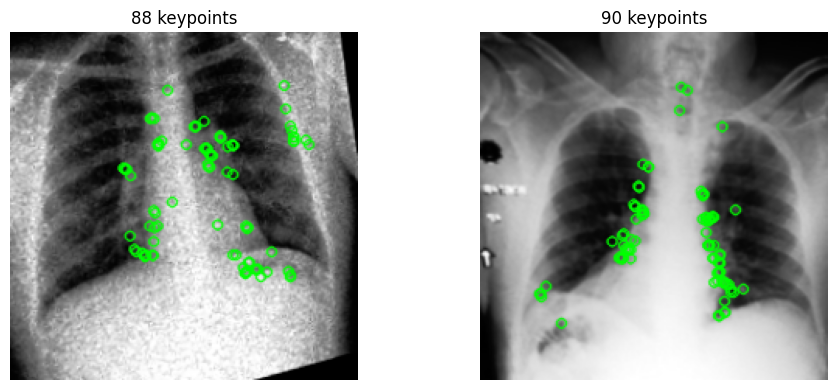

In [14]:
# 3. Quick visualization
def easy_visualize_keypoints(images, num_samples=2):
    detector = cv2.ORB_create(nfeatures=100)
    plt.figure(figsize=(10, 4))
    
    for i in range(num_samples):
        idx = np.random.randint(0, len(images))
        img = (images[idx] * 255).astype(np.uint8) if images[idx].dtype == np.float32 else images[idx]
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        keypoints = detector.detect(gray, None)
        img_with_kp = cv2.drawKeypoints(gray, keypoints, None, color=(0, 255, 0))
        
        plt.subplot(1, num_samples, i+1)
        plt.imshow(img_with_kp, cmap='gray')
        plt.title(f'{len(keypoints)} keypoints')
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

easy_visualize_keypoints(X_train)

In [15]:
# 4. Save results
np.save(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\feature_extracted_data\train_keypoints_count.npy', train_kp_count)
np.save(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\feature_extracted_data\test_keypoints_count.npy', test_kp_count)

print(" OpenCV feature extraction COMPLETE!")
print(f"Train: {len(train_kp_count)} images, avg {np.mean(train_kp_count):.1f} keypoints")

 OpenCV feature extraction COMPLETE!
Train: 2208 images, avg 76.2 keypoints


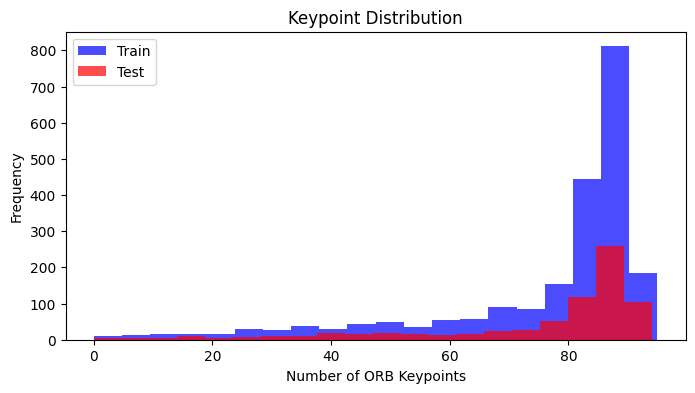

In [16]:
# SIMPLE: Show basic stats
plt.figure(figsize=(8, 4))

plt.hist(train_kp_count, bins=20, alpha=0.7, label='Train', color='blue')
plt.hist(test_kp_count, bins=20, alpha=0.7, label='Test', color='red')

plt.xlabel('Number of ORB Keypoints')
plt.ylabel('Frequency')
plt.title('Keypoint Distribution')
plt.legend()
plt.show()

In [17]:
# # Oversampling: Balancing Multi-Label Training Data
# def balance_multilabel_data(X, y):
#     class_counts = np.sum(y, axis=0)
#     max_count = int(np.max(class_counts))

#     X_balanced = []
#     y_balanced = []

#     for class_idx in range(CLASSES):
#         indices = [i for i in range(len(y)) if y[i][class_idx] == 1]
#         if not indices:
#             continue

#         repeat_factor = int(np.ceil(max_count / len(indices)))
#         sampled_indices = np.tile(indices, repeat_factor)[:max_count]

#         for i in sampled_indices:
#             X_balanced.append(X[i])
#             y_balanced.append(y[i])

#     return np.array(X_balanced), np.array(y_balanced)

# X_train, y_train = balance_multilabel_data(X_train, y_train)

In [18]:
import tensorflow as tf
from tensorflow.keras import models, layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Model

# GPU configuration
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)

# Create base CNN
base_cnn = EfficientNetB0(
    weights="imagenet", 
    include_top=False, 
    input_shape=(224, 224, 3),
    pooling=None
)

# Freeze early layers
for layer in base_cnn.layers[:-10]:
    layer.trainable = False

# Build model using Functional API
x = base_cnn.output
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)
output = layers.Dense(CLASSES, activation='sigmoid')(x)

cnn_model = Model(inputs=base_cnn.input, outputs=output)

# Compile the model
cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="binary_crossentropy",
    metrics=["accuracy"]
)

# Model summary
print(cnn_model.summary())

# Early stopping callback
early_stop = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 rescaling (Rescaling)       (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 normalization (Normalizati  (None, 224, 224, 3)          7         ['rescaling[0][0]']           
 on)                                                                                              
                                                                                                  
 rescaling_1 (Rescaling)     (None, 224, 224, 3)          0         ['normalization[0][0]'] 

In [19]:
import tensorflow as tf
from tensorflow.keras import Model

# Clear all memory first
tf.keras.backend.clear_session()
gc.collect()

cnn_feature_extractor = Model(inputs=cnn_model.input, outputs=cnn_model.layers[-2].output)

def predict_in_batches_memory_safe(model, X_data, batch_size=8):  # Even smaller batch size
    """Predict features with aggressive memory management"""
    features = []
    n_samples = len(X_data)
    
    for i in range(0, n_samples, batch_size):
        end_idx = min(i + batch_size, n_samples)
        batch = X_data[i:end_idx]
        
        # Predict and immediately clear
        batch_features = model.predict(batch, verbose=0)
        features.append(batch_features)
        
        # Aggressive memory cleanup
        del batch
        gc.collect()
        
        if i % (batch_size * 5) == 0:
            print(f"Processed {end_idx}/{n_samples} samples")
            tf.keras.backend.clear_session()
    
    return np.concatenate(features, axis=0)

# Extract with very small batch size
cnn_features_train = predict_in_batches_memory_safe(cnn_feature_extractor, X_train, batch_size=16)
cnn_features_test = predict_in_batches_memory_safe(cnn_feature_extractor, X_test, batch_size=16)

Processed 16/2208 samples
Processed 96/2208 samples
Processed 176/2208 samples
Processed 256/2208 samples
Processed 336/2208 samples
Processed 416/2208 samples
Processed 496/2208 samples
Processed 576/2208 samples
Processed 656/2208 samples
Processed 736/2208 samples
Processed 816/2208 samples
Processed 896/2208 samples
Processed 976/2208 samples
Processed 1056/2208 samples
Processed 1136/2208 samples
Processed 1216/2208 samples
Processed 1296/2208 samples
Processed 1376/2208 samples
Processed 1456/2208 samples
Processed 1536/2208 samples
Processed 1616/2208 samples
Processed 1696/2208 samples
Processed 1776/2208 samples
Processed 1856/2208 samples
Processed 1936/2208 samples
Processed 2016/2208 samples
Processed 2096/2208 samples
Processed 2176/2208 samples
Processed 16/737 samples
Processed 96/737 samples
Processed 176/737 samples
Processed 256/737 samples
Processed 336/737 samples
Processed 416/737 samples
Processed 496/737 samples
Processed 576/737 samples
Processed 656/737 samples

In [20]:
print(cnn_features_train.shape, train_kp_count.shape)
print(cnn_features_test.shape, test_kp_count.shape)

(2208, 1280) (2208,)
(737, 1280) (737,)


In [21]:
# Reshape keypoint counts into (n_samples, 1)
train_kp_count = train_kp_count.reshape(-1, 1)
test_kp_count = test_kp_count.reshape(-1, 1)

X_train_hybrid = np.concatenate([cnn_features_train, train_kp_count], axis=1)
X_test_hybrid  = np.concatenate([cnn_features_test, test_kp_count], axis=1)

print(X_train_hybrid.shape)
print(X_test_hybrid.shape)

(2208, 1281)
(737, 1281)


In [22]:
# from xgboost import XGBClassifier
# from sklearn.model_selection import RandomizedSearchCV
# from sklearn.multioutput import MultiOutputClassifier
# import numpy as np


# # param_grid = {
# #     "estimator__n_estimators": [100, 200],
# #     "estimator__max_depth": [3, 5],
# #     "estimator__learning_rate": [0.05, 0.1],
# #     "estimator__subsample": [0.8, 1.0],
# #     "estimator__colsample_bytree": [0.8, 1.0]
# # }


In [23]:

# xgb_base = XGBClassifier(
#     use_label_encoder=False,
#     eval_metric="logloss",
#     random_state=42,
#     n_jobs=-1,
#     tree_method="hist"
# )

# multi_xgb = MultiOutputClassifier(xgb_base, n_jobs=-1)


# random_search = RandomizedSearchCV(
#     estimator=multi_xgb,
#     param_distributions=param_grid,
#     n_iter=5,
#     cv=2,
#     scoring="f1_micro",
#     verbose=2,
#     random_state=42,
#     n_jobs=-1
# )


In [24]:

# random_search.fit(X_train_hybrid, y_train)

# print("Best Params:", random_search.best_params_) 
# print("Best Score:", random_search.best_score_)

The model is very big so i directly use params

In [25]:
from xgboost import XGBClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import classification_report

xgb_base = XGBClassifier(
    n_estimators=200,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    use_label_encoder=False,
    eval_metric="logloss",
    random_state=42,
    n_jobs=-1
)

hybrid_model = MultiOutputClassifier(xgb_base)
hybrid_model.fit(X_train_hybrid, y_train)

c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\xgboost\training.py:183: UserWarning: [15:35:23] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\xgboost\training.py:183: UserWarning: [15:35:46] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\xgboost\training.py:183: UserWarning: [15:36:06] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\xgboost\training.py:183: UserWarning: [15:36:26] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Par

,estimator,"XGBClassifier...ree=None, ...)"
,n_jobs,None
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None


In [26]:
Y_CLASSES= np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\classes.npy', allow_pickle=True)

Y_CLASSES

array(['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema',
       'Effusion', 'Emphysema', 'Fibrosis', 'Healthy', 'Hernia',
       'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening',
       'Pneumonia', 'Pneumothorax'], dtype=object)

In [27]:
hybrid_preds = hybrid_model.predict(X_test_hybrid)

print("Hybrid XGBoost Model Evaluation:")
print(classification_report(y_test, hybrid_preds, target_names=Y_CLASSES))

Hybrid XGBoost Model Evaluation:
                    precision    recall  f1-score   support

       Atelectasis       0.33      0.02      0.03        64
      Cardiomegaly       0.00      0.00      0.00        27
     Consolidation       0.00      0.00      0.00        27
             Edema       0.00      0.00      0.00         9
          Effusion       0.00      0.00      0.00        69
         Emphysema       0.00      0.00      0.00        15
          Fibrosis       0.00      0.00      0.00        30
           Healthy       0.60      0.71      0.65       416
            Hernia       0.00      0.00      0.00         3
      Infiltration       0.33      0.02      0.04       131
              Mass       0.00      0.00      0.00        15
            Nodule       0.00      0.00      0.00        39
Pleural_Thickening       0.00      0.00      0.00        24
         Pneumonia       0.00      0.00      0.00         8
      Pneumothorax       0.00      0.00      0.00        18

     

c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
c:\Users\THAMIZH\miniconda3\envs\gpu_env\lib\site-packages\sklearn\metrics\_classification.py:1731: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])


## Save Model

In [28]:
# import joblib

# joblib.dump(hybrid_model, r"E:\AIML-Projects\Chest-X-ray-Disease-Classification\models\hybrid_xgb_model.pkl")

# joblib.dump(cnn_model, r"E:\AIML-Projects\Chest-X-ray-Disease-Classification\models\cnn_model.pkl")

### Grad-CAM Visualization

In [29]:
# # Load model
# import joblib

# hybrid_model = joblib.load(r"E:\AIML-Projects\Chest-X-ray-Disease-Classification\models\hybrid_xgb_model.pkl")
# cnn_model = joblib.load(r"E:\AIML-Projects\Chest-X-ray-Disease-Classification\models\cnn_model.pkl")

In [30]:
# X_test = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\X_test.npy', allow_pickle=True)
# y_test = np.load(r'E:\AIML-Projects\Chest-X-ray-Disease-Classification\Preprocessed_Data\y_test.npy', allow_pickle=True)


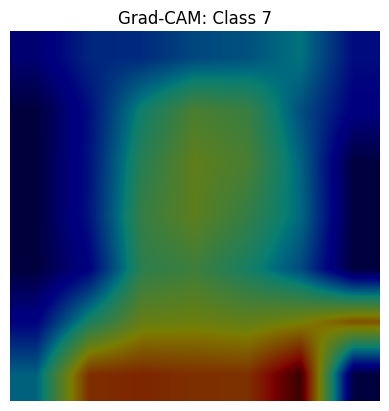

In [ ]:


def grad_cam_visualize(model, img_array, class_index, layer_name='top_activation'):
    grad_model = Model(
        inputs=model.inputs,
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(np.array([img_array]))
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)[0]
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1))

    conv_outputs = conv_outputs[0]
    heatmap = conv_outputs @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap).numpy()

    heatmap = np.maximum(heatmap, 0)
    heatmap /= (np.max(heatmap) + 1e-5)

    plt.imshow(img_array.astype(np.uint8))
    plt.imshow(cv2.resize(heatmap, (224, 224)), cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title(f"Grad-CAM: Class {class_index}")
    plt.show()


# Example usage


example_idx = 8
example_class = np.argmax(y_test[example_idx])

grad_cam_visualize(cnn_model, X_test[example_idx], class_index=example_class)


### ROC Curve Visualization

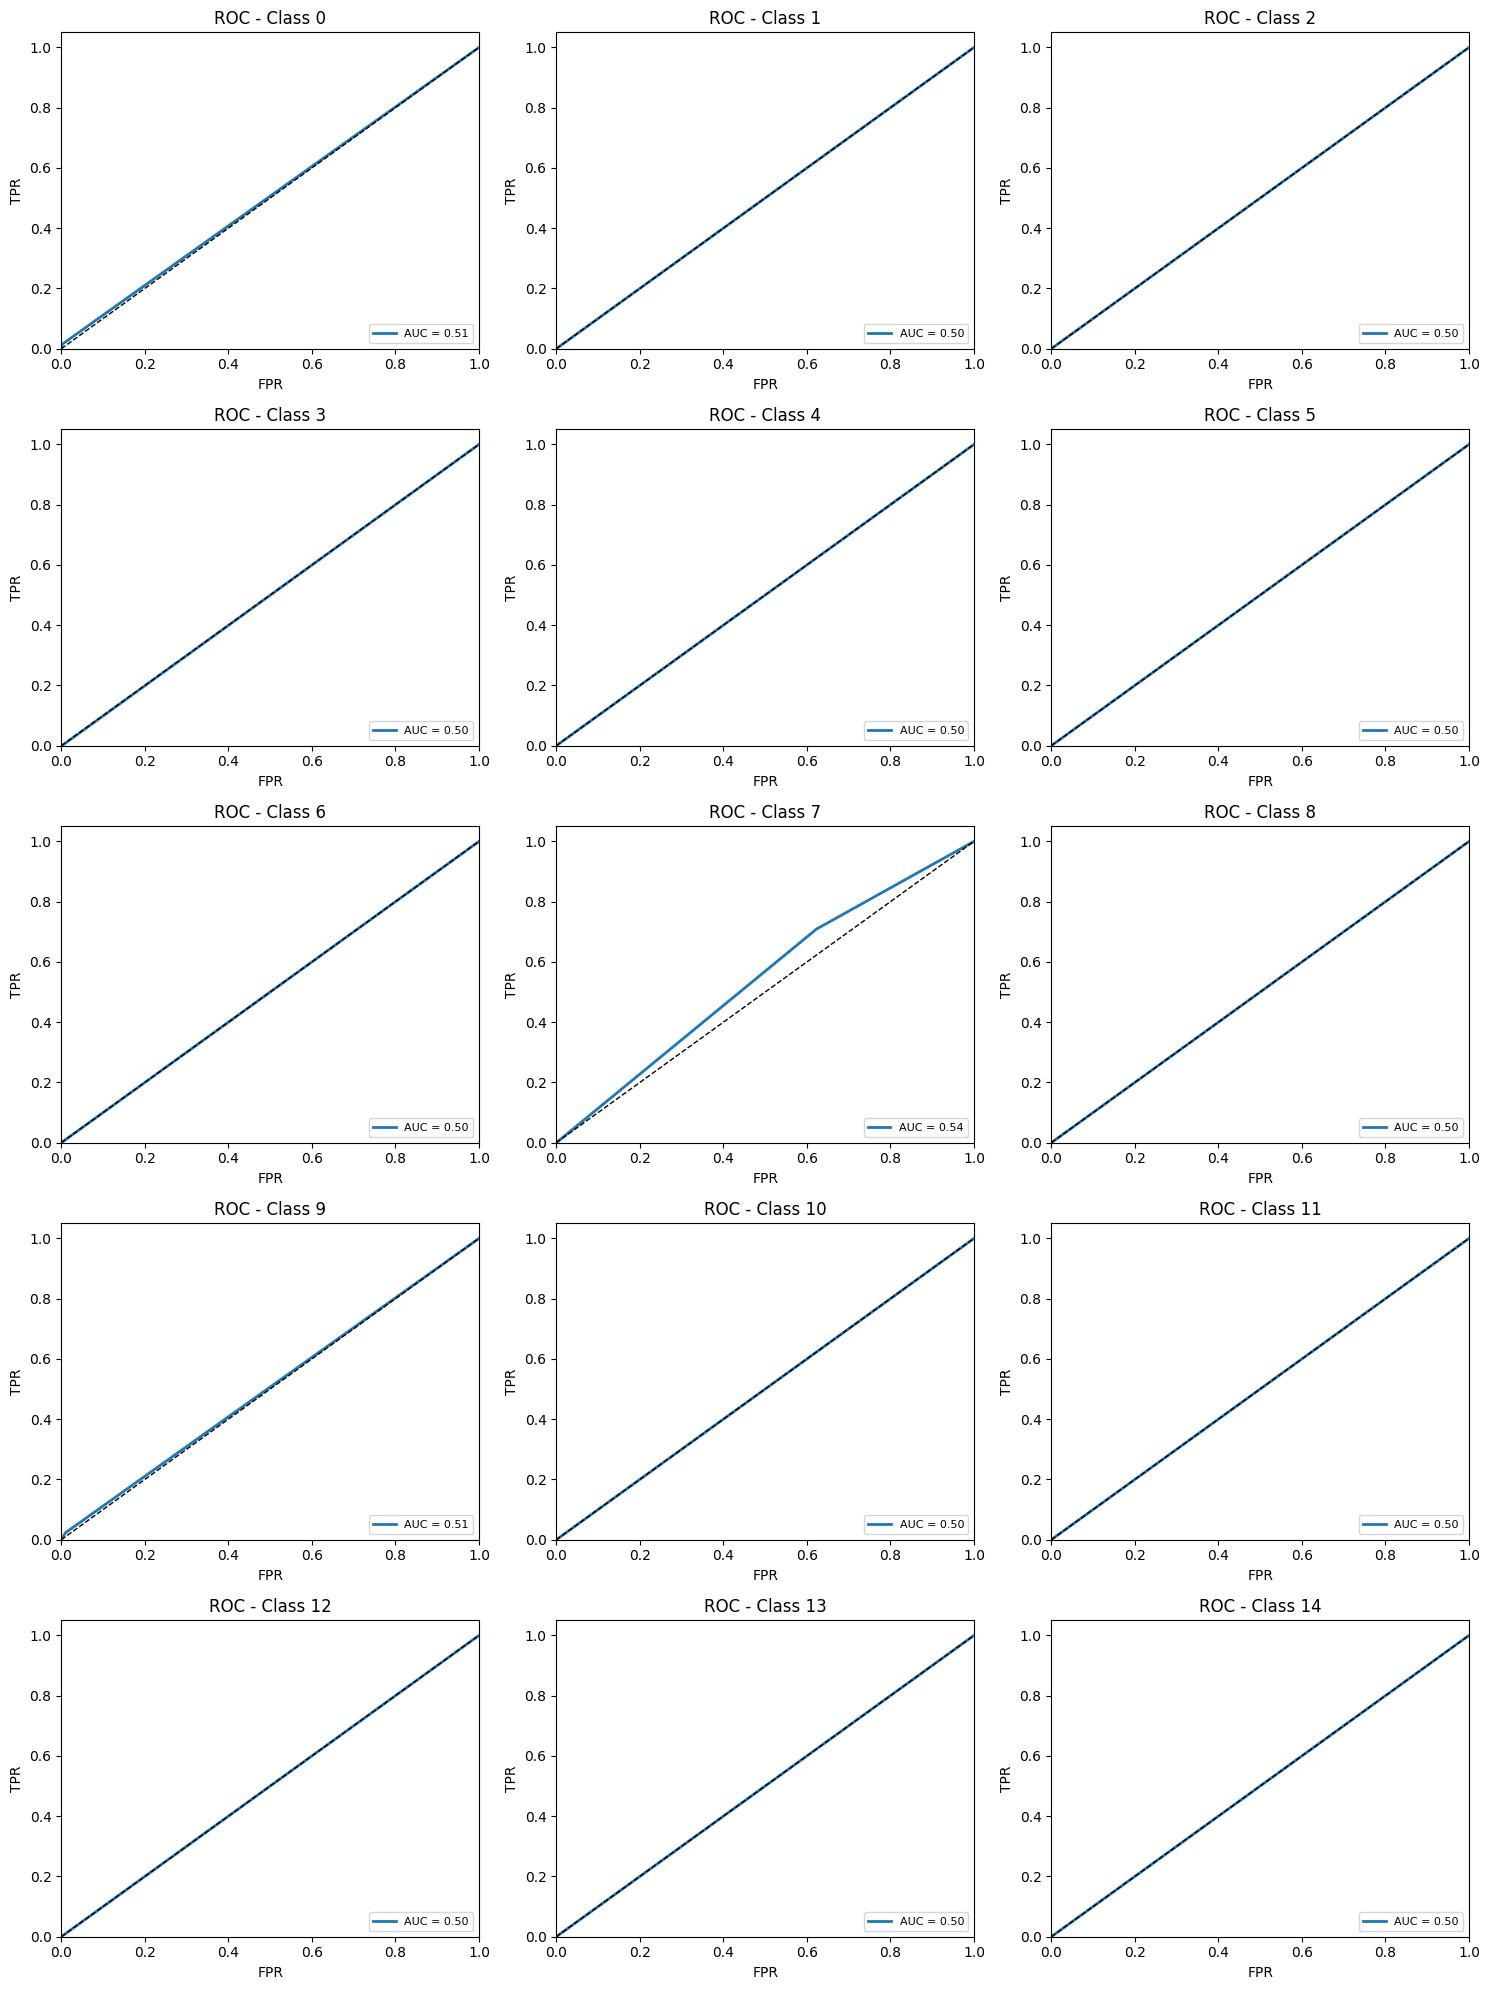

In [37]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import numpy as np

hybrid_preds = np.array(hybrid_preds)

fpr, tpr, roc_auc = {}, {}, {}

for i in range(len(Y_CLASSES)):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], hybrid_preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

n_classes = len(Y_CLASSES)
cols = 3
rows = int(np.ceil(n_classes / cols))

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))
axes = axes.ravel()

for i in range(n_classes):
    axes[i].plot(fpr[i], tpr[i], lw=2,
                 label=f"AUC = {roc_auc[i]:.2f}")
    axes[i].plot([0, 1], [0, 1], 'k--', lw=1)
    axes[i].set_xlim([0.0, 1.0])
    axes[i].set_ylim([0.0, 1.05])
    axes[i].set_xlabel("FPR")
    axes[i].set_ylabel("TPR")

    if isinstance(CLASSES, (list, np.ndarray)):
        axes[i].set_title(f"ROC - {CLASSES[i]}")
    else:
        axes[i].set_title(f"ROC - Class {i}")

    axes[i].legend(loc="lower right", fontsize=8)

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()

plt.savefig(r"E:\AIML-Projects\Chest-X-ray-Disease-Classification\curves\hybrid_roc_curves")
plt.show()

In [38]:
import joblib

joblib.dump(hybrid_model, r"E:\AIML-Projects\Chest-X-ray-Disease-Classification\models\hybrid_xgb_model.pkl")

joblib.dump(cnn_model, r"E:\AIML-Projects\Chest-X-ray-Disease-Classification\models\cnn_model.pkl")

['E:\\AIML-Projects\\Chest-X-ray-Disease-Classification\\models\\cnn_model.pkl']